# Table of Contents
1. [Author](#author)
2. [Introduction](#introduction)
3. [Packages and Import](#packages-and-import)
4. [Evaluation Functions](#evaluation-functions)
6. [Data Analysis](#data-analysis)
7. [Feature Engineering](#feature-engineering)
8. [Train-Test Split](#train-test-split)
9. [Dimensionality Reduction](#dimensionality-reduction)
10. [Logistic Regression](#logistic-regression)
11. [SVM](#svm)
12. [Random Forest](#random-forest)
13. [Soft Voting](#soft-voting)
14. [Stacking](#stacking)
15. [Model Evaluation](#model-evaluation)
16. [Conclusions](#conclusions)

# Author
<a id='author'><a>
Sergio Sanz

# Introduction
<a id='introduction'><a>
    
## Objective
The objective of this work is to investigate the potential of ensemble architectures to improve prediction in binary classification problems. In this notebook, we will utilize a heart disease database in order to detect, using machine-learning models, the presence of heart disease in patients.
   
The evaluated models include: **Logistic Regression**, **Support Vector Machine (SVM)**, **Random Forest**, **Soft-Voting**, and **Stacking**. The last three correspond to ensemble architectures.

## Data Overview

| Column | Additional Information |
|--------|------------------------|
| age | The age of the patient. |
| sex | The gender of the patient (0 = female, 1 = male). |
| cp| Chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic). |
| trestbps| Resting blood pressure (in mm Hg). |
| chol | Serum cholesterol level (in mg/dl). |
| fbs | Fasting blood sugar (> 120 mg/dl) (1 = true, 0 = false). |
| restecg | Resting electrocardiographic results (0 = normal, 1 = having ST-T wave abnormality, 2 = probable or definite left ventricular hypertrophy). |
| thalach | Maximum heart rate achieved. |
| exang | Exercise-induced angina (1 = yes, 0 = no). |
| oldpeak | ST depression induced by exercise relative to rest. |
| slope | Slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping) |
| caa | Number of major vessels colored by fluoroscopy. |
| thall | Thalassemia (a type of blood disorder) results (3 = normal, 6 = fixed defect, 7 = reversible defect). |
| output |  0 = little risk of heart attack, 1 = high risk of heart attack |

More information about this dataset can be found here: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset

# Packages and Import
<a id='packages-and-import'><a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import itertools

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, FunctionTransformer, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score, f1_score, fbeta_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (8, 6)

RSEED=42

In [2]:
df_heart = pd.read_csv("./data/heart.csv")
df = df_heart.copy()

# Evaluation Functions
<a id='evaluation-functions'><a>

In [3]:
def plot_correlation(df, method='pearson', figsize=(10,10)):
    '''
    This function plots the correlation of the features in a dataset.
    '''
    correlations = df.corr(method=method)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()    
    sns.heatmap(correlations , vmax=1, vmin=-1, annot=True, cmap="YlGnBu", fmt='.2f', ax=ax)    
    ax.tick_params(axis='x', labelsize=10)  # Set x-axis label size
    ax.tick_params(axis='y', labelsize=10)  # Set y-axis label size
    plt.show()

    return fig, ax

def plot_distributions(df, figsize=(8,6)):
    '''
    This function plots the box plots and histograms of the features in a dataset.
    '''
    num_features = list(df.columns[df.dtypes!=object])
    for feature in num_features:
        fig = plt.figure(figsize=figsize)
        ax = fig.subplots(1,2)
        sns.boxplot(data=df, x=feature, ax=ax[0])
        sns.histplot(data=df, x=feature, ax=ax[1], color='#ff4125', kde=True)
        #fig.set_size_inches(15, 5)
        plt.suptitle(feature)  # Adds a title to the entire figure
        plt.show()
    
    return fig, ax

def predict_and_print_scores(model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,                             
                             training=True,
                             test=True,
                             accuracy=True,
                             recall=True,
                             precision=True,
                             fbeta=[True, 1.0],
                             roc_auc=True,
                             matrix=True,
                             figsize=(3,2),
                             cmap='YlGn'):
    
    '''
    Given an already trained model, this function predicts and print some performance scores training and/or testing data.
    The supported metrics are: accuracy, recall, precision, fbeta_score (and f1_score if beta = 1.0), roc_auc.
    If the input parameter "matrix" is set to True, the function plot the confusion matrix with a color map given in "cmap".

    model             Trained model
    X_train           Training data with features
    y_train           Training data with labels or targets
    X_test            Testing data with features
    y_test            Testing data with labels or targets                             
    training=True     True: print scores on the training set
    test=True         True: print scores on the testing set
    accuracy=True     True: print accuracy_score()
    recall=True       True: print recall_score()
    precision=True    True: print precision_score()
    fbeta=[True, 1.0] [True, beta]: print fbeta_score. If beta = 1.0: f1_score
    roc_auc=True      True: print roc_auc_score()
    matrix=True       True: plot confusion matrix
    figsize=(3,2)     Figure size for the confusion matrix
    cmap='YlGn')      Color map for the confusion matrix
    
    Possible color maps: 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                        'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                        'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
    
    Returns: fig, ax: the figure objects of the confusion matrix (if enabled)
    '''

    # Prediction
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
            
    # Scores
    if accuracy:
        if training:
            print("Accuracy on training set:", round(accuracy_score(y_train, y_pred_train), 2))
        if test:
            print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test), 2))
        print("--------"*5)
    
    if recall:        
        if training:
            print("Recall on training set:", round(recall_score(y_train, y_pred_train), 2))
        if test:
            print("Recall on test set:", round(recall_score(y_test, y_pred_test), 2))
        print("--------"*5)
    
    if precision:
        if training:
            print("Precision on training set:", round(precision_score(y_train, y_pred_train), 2))
        if test:
            print("Precision on test set:", round(precision_score(y_test, y_pred_test), 2))
        print("--------"*5)

    if fbeta[0]:
        if training:
            print("fbeta_score on training set:", round(fbeta_score(y_train, y_pred_train, beta=fbeta[1]), 2))
        if test:
            print("fbeta_score on test set:", round(fbeta_score(y_test, y_pred_test, beta=fbeta[1]), 2))
        print("--------"*5)

    if roc_auc:
        y_pred_train_p = model.predict_proba(X_train)[:,1]
        y_pred_test_p = model.predict_proba(X_test)[:,1]
        if training:
            print('roc_auc_score on trainig set: ', round(roc_auc_score(y_train, y_pred_train_p), 2))
        if test:
            print('roc_auc_score on test set: ', round(roc_auc_score(y_test, y_pred_test_p), 2))
        print("--------"*5)
    
    # Plot confusion matrix 
    if matrix:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
        sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap=cmap);
        plt.title('Test Set')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')                 
        
def train_crossval_predict_score(model,
                                 hyperparams,
                                 X_train,
                                 y_train,
                                 X_test,
                                 y_test,
                                 cv=5,
                                 scoring='accuracy',
                                 verbose=0,
                                 n_jobs=-1,
                                 cross_val='full',
                                 random_state='None',
                                 training=True,
                                 test=True,
                                 accuracy=True,
                                 recall=True,
                                 precision=True,
                                 fbeta=[True, 1.0],
                                 roc_auc=True,
                                 matrix=True,
                                 figsize=(3,2),
                                 cmap='YlGn'):
                                 
    '''
    Given an instantiated model, this function trains, cross-validate, predicts, and prints some performance scores training and/or testing data.
    The cross-validation strategy is selected with the input parameters "cross_val".
    The supported metrics are: accuracy, recall, precision, fbeta_score (and f1_score if beta = 1.0), roc_auc.
    If the input parameter "matrix" is set to True, the function plot the confusion matrix with a color map given in "cmap".

    model                 #Instantiated model
    hyperparams           #Dictionary including hyperparameters
    X_train               #Training data with features
    y_train               #Training data with labels or targets
    X_test                #Testing data with features
    y_test                #Testing data with labels or targets
    cv=5                  #Number of cross-validation folds
    scoring='accuracy'    #Scoring method
    verbose=0             #Verbose
    n_jobs=-1             #Number of jobs in parallel
    cross_val='full'      #'Full'/'full': Apply GridSearchCV. 'Random'/'random': Apply RandomSearchCV
    random_state          #Random state parameter for RandomSearchCV: 'None' or an integer
    training=True         #True: print scores on the training set
    test=True             #True: print scores on the testing set
    accuracy=True         #True: print accuracy_score()
    recall=True           #True: print recall_score()
    precision=True        #True: print precision_score()
    fbeta=[True, 1.0]     #[True, beta]: print fbeta_score. If beta = 1.0: f1_score
    roc_auc=True          #True: print roc_auc_score()
    matrix=True           #True: plot confusion matrix
    figsize=(3,2)         #Figure size for the confusion matrix
    cmap='YlGn'):         #Color map for the confusion matrix

    Possible color maps: 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                        'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                        'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
    
    Returns:
    - best_model: object of the best model after cross-validation
    - best_params: hyperparameters of the best model
    - fig, ax: the figure objects of the confusion matrix (if enabled)
'''

    # Cross-validation
    if cross_val == 'Full' or cross_val == 'full':
        grid_model = GridSearchCV(model, param_grid=hyperparams, cv=cv, scoring=scoring, verbose=verbose, n_jobs=n_jobs)
    elif cross_val == 'Random' or cross_val == 'random':        
        grid_model = RandomizedSearchCV(model, param_distributions=hyperparams, cv=cv, scoring=scoring, random_state=random_state, verbose=verbose, n_jobs=n_jobs)
        
    # Fit
    grid_model.fit(X_train, y_train)
    best_model = grid_model.best_estimator_
    best_params = grid_model.best_params_
    print('Best params:', grid_model.best_params_)
    print("--------"*5)
    
    # Predict and print results
    predict_and_print_scores(best_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             training=training,
                             test=test,
                             accuracy=accuracy,
                             recall=recall,
                             precision=precision,
                             fbeta=fbeta,
                             roc_auc=roc_auc,
                             matrix=matrix,
                             figsize=figsize,
                             cmap=cmap)
    
    return best_model, best_params


def find_roc_threshold_tpr(model, X, y, value_target):
    """
    This function calculates the threshold and false positive rate corresponding to a true positive rate of value_target (from 0 to 1).
    
    model                 # Trained model
    X                     # Feature dataset
    y                     # Target dataset
    value_target          # True positive rate value
    
    Returns:
    threshold             # Threshold value
    false_positive_rate   # False positive rate value
    """

    fpr, tpr, thr = roc_curve(y, model.predict_proba(X)[:,1])
    old_diff = 100000000
    for index, value in enumerate(tpr):
        new_diff = abs(value_target - value)
        if new_diff < old_diff:
            false_pos_rate = fpr[index]
            threshold = thr[index]
            old_diff = new_diff

    return threshold, false_pos_rate

def find_roc_threshold_f1(model, X, y):
    """
    This function calculates the threshold in the ROC curve that maximizes the f1 score.
    model                 # Trained model
    X                     # Feature dataset
    y                     # Target dataset
    
    Returns:  
    best_threshold        # Threshold value
    best_f1_score         # False positive rate value
    """
    
    pred_ = model.predict_proba(X)[:,1]
    best_threshold = 0.5
    best_f1_score = 0.0
    for value in np.arange(1, 10, 0.5):
        pred_tmp = np.where(pred_ >= float(value/10), 1, 0)
        cost = f1_score(y, pred_tmp)
        if cost > best_f1_score:
            best_f1_score = cost
            best_threshold = float(value/10)
      
    return best_threshold, best_f1_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges,
                          figsize=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # Confusion matrix
    #cm = confusion_matrix(test_labels, rf_predictions)
    #plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
    #                      title = 'Health Confusion Matrix')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the confusion matrix
    plt.figure(figsize = figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 18)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 18,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.grid(False)
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    plt.show()

def plot_roc_curves(model_dic, X_test, y_test, figsize=(6,5)):
    """
    This function plots the ROC curves of the models defined in model_dic.
    The model_dic format is {'model_label' : [model_object, color-line'], ...}. Example:
    model_dic = {['model_1' : [model_1, 'r-'], 'model_2' : [model_2, 'b-']}
    """
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    for key, _ in model_dic.items():
        model = model_dic[key][0]
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        plt.plot(fpr, tpr, model_dic[key][1], label=key)
    plt.plot([0,1],[0,1],'k:',label='Random')
    plt.plot([0,0,1,1],[0,1,1,1],'k--',label='Perfect')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate (Recall)')
    ax.legend()
    plt.grid(True)
    plt.show()
    return fig, ax

# Data Analysis
<a id='data-analysis'><a>

In [4]:
df.head(2)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1


In [5]:
print(f"Number of inputs: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

Number of inputs: 303
Number of features: 14


In [6]:
# All the features are int64 and float64, but some of them are, in fact, categorical
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:
# Change the name of the columns
dict = {'age' : 'age', # numerical OK!
        'sex' : 'sex', # categorical (binary) OK!
        'cp' : 'chest_pain_type', # categorical OK!
        'trtbps' : 'resting_blood_pressure', # numerical OK!
        'chol' : 'serum_cholestoral', # numerical OK!
        'fbs' : 'fasting_blood_sugar', # categorical (binary) OK!
        'restecg' : 'resting_electrocard_results', # categorical OK!
        'thalachh' : 'maximum_heartrate', # numerical OK!
        'exng' : 'exercise_induced_angina', # categorical (binary) OK!
        'oldpeak' : 'oldpeak', # numerical OK!
        'slp' : 'slope_peak_exercise_segment', # categorical OK!
        'caa' : 'no_major_vessels_col', # numerical OK!
        'thall' : 'thal', # categorical (3 values according to description, but 4!)
        'output' : 'output'} # binary
df = df.rename(columns=dict)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
chest_pain_type,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
resting_blood_pressure,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
serum_cholestoral,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fasting_blood_sugar,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
resting_electrocard_results,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
maximum_heartrate,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exercise_induced_angina,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [9]:
df.nunique()

age                             41
sex                              2
chest_pain_type                  4
resting_blood_pressure          49
serum_cholestoral              152
fasting_blood_sugar              2
resting_electrocard_results      3
maximum_heartrate               91
exercise_induced_angina          2
oldpeak                         40
slope_peak_exercise_segment      3
no_major_vessels_col             5
thal                             4
output                           2
dtype: int64

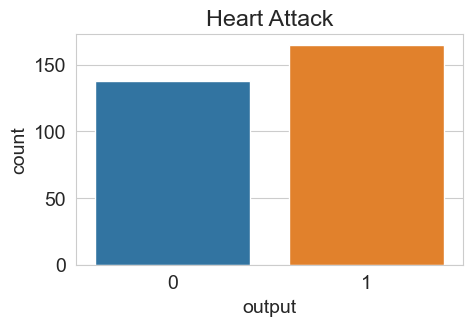

In [10]:
# The two classes are well balanced
fig, ax = plt.subplots(figsize=(5,3))
plt.title('Heart Attack')
ax = sns.countplot(x=df.output)

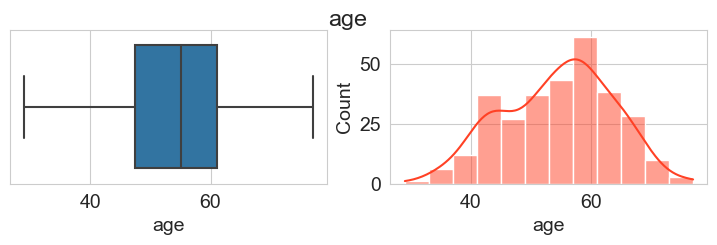

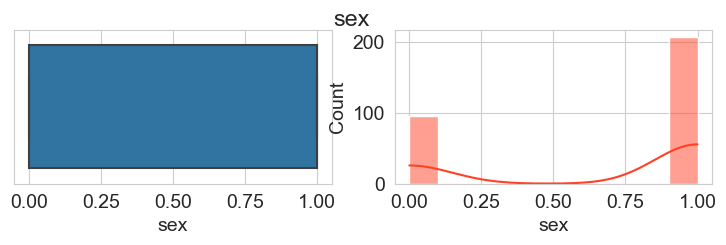

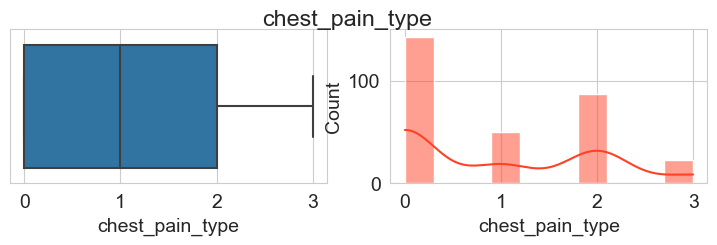

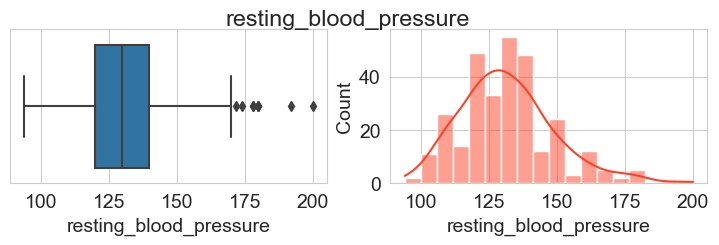

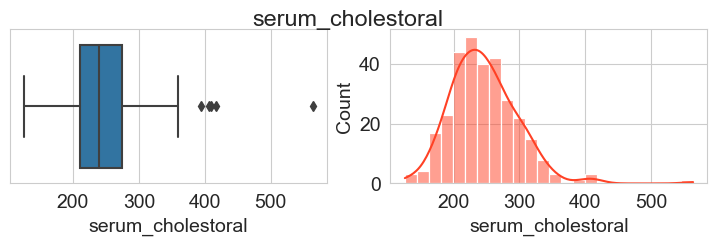

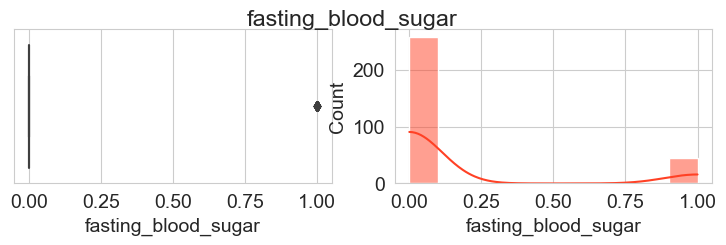

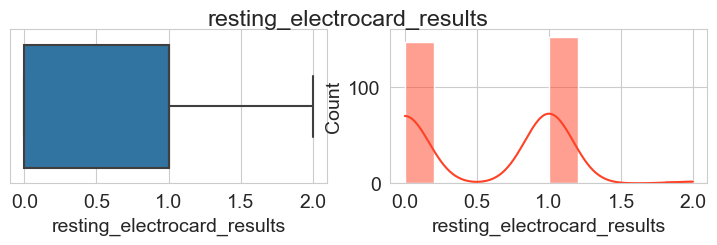

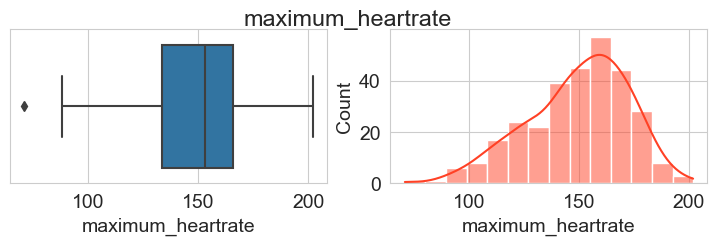

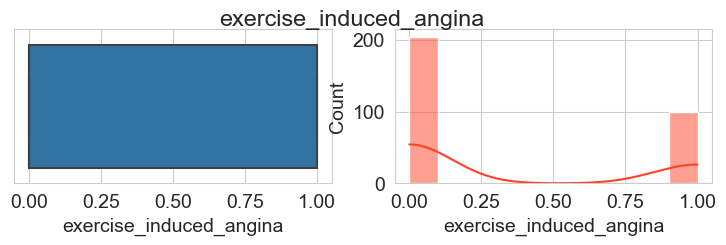

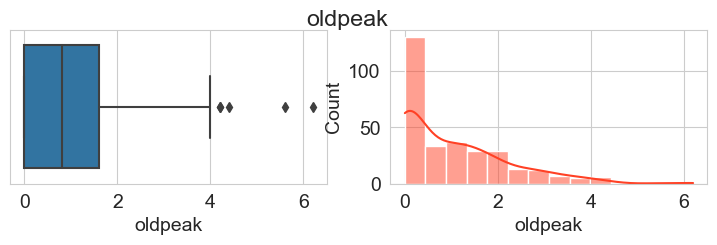

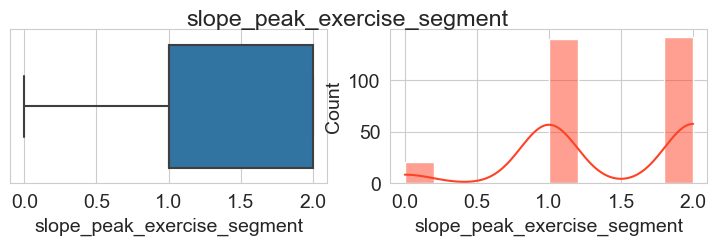

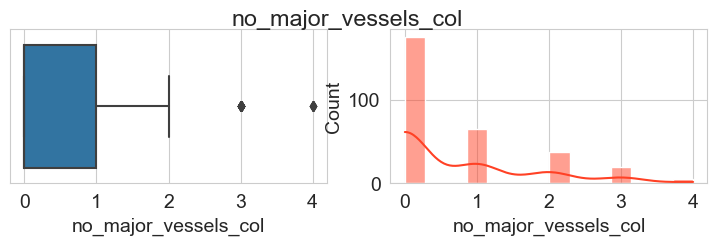

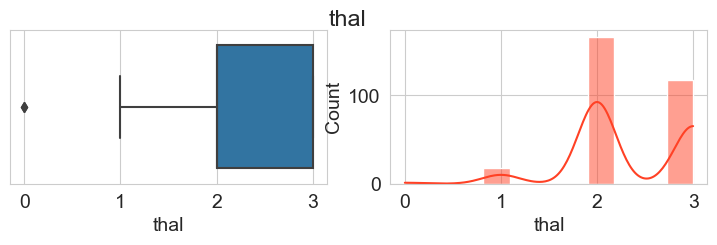

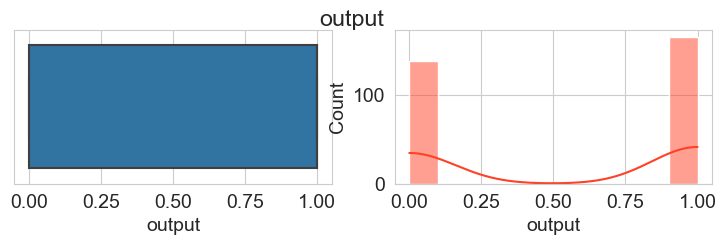

In [11]:
# Analysis of the distributions
fig, ax = plot_distributions(df, figsize=(9,2))

According to these plots, some features such as "resting_blood_pressure" and "serum_cholestoral" present outliers. However, these high values might indicate risk of heart attack, so it is better to keep them.

As for the feature called "thal", the description indicates three possible values, but there are four. The one with category "0"  is given by two samples only. Perhaps it is not correct. For safety, let's keep this feature unaltered.

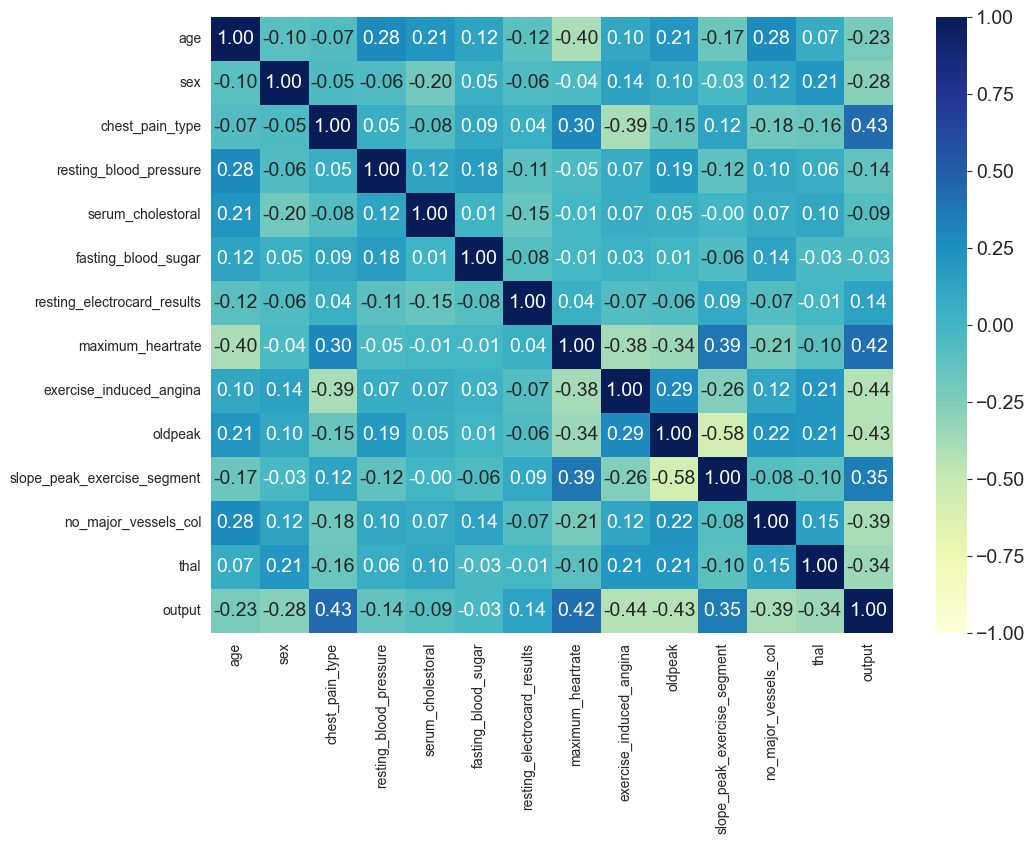

In [12]:
# Plot correlation matrix
fig, ax = plot_correlation(df, figsize=(11,8))

The correlation matrix shows that some features present moderate correlation with the target feature.

# Feature Engineering
<a id='feature-engineering'><a>

In [13]:
# Convert age into categorical
bins = [0, 40, 50, 60, 70, 80]
labels = ['29-40','40-50','50-60','60-70','70-80']
age_cat = pd.CategoricalDtype(categories=labels, ordered=True)
df['cat_age'] = pd.cut(df['age'], bins=bins, labels=labels).astype(age_cat)

In [14]:
# Binary features
binary_features = ['sex', 'fasting_blood_sugar', 'exercise_induced_angina']

# Categorical features
categorical_features = ['cat_age', 'chest_pain_type', 'resting_electrocard_results', 'slope_peak_exercise_segment', 'thal']

# Numerical features
numerical_features = ['resting_blood_pressure', 'serum_cholestoral', 'maximum_heartrate', 'oldpeak', 'no_major_vessels_col']

In [15]:
# Convert categorical features into 'category'
for feature in categorical_features:
    df[feature] = df[feature].astype('category')

# Convert numerical and binary features into 'int32'
for feature in [numerical_features, binary_features]:
    df[feature] = df[feature].astype(int)

# Train-Test Split
<a id='train-test-split'><a>

In [16]:
X = df.drop('output', axis=1)
y = df['output']

# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED, stratify=y)

print(f"X_train: {X_train.shape[0]} samples - {X_train.shape[1]} features ")
print(f"y_train: {y_train.shape[0]} samples")
print(f"X_test: {X_test.shape[0]} samples - {X_test.shape[1]} features ")
print(f"y_test: {y_test.shape[0]} samples")

X_train: 242 samples - 14 features 
y_train: 242 samples
X_test: 61 samples - 14 features 
y_test: 61 samples


# Dimensionality Reduction
<a id='dimensionality-reduction'><a>

In this particular problem consisting of predicting heart disease, reducing the number of features in the dataset may result in an improvement of the performance scores. The method called **SelectKBest** can be used to select only the most important features.

This code can be used to analyze the importance of the features. The **chi2** function can be used for categorical and binary features, and **f_classif** for numerical features.
```
select_example = SelectKBest(score_func=chi2, k='all')
select_example.fit(X_train[binary_features], y_train)
sorted(select_example.pvalues_)
```

# Logistic Regression
<a id='logistic-regression'><a>

In [17]:
# Pipeline
pipe_numerical = Pipeline([
    ('scaler', StandardScaler()),
    ('kbest', SelectKBest(score_func=f_classif, k=3))
])

pipe_categorical = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ('kbest', SelectKBest(score_func=chi2, k=2))
])

pipe_binary = Pipeline([
    ('kbest', SelectKBest(score_func=chi2, k=2))
])

preprocessing = ColumnTransformer(transformers=[
    ('numerical', pipe_numerical, numerical_features),
    ('categorical', pipe_categorical, categorical_features),
    ('binary', pipe_binary, binary_features),
]) 

pipe_lr = Pipeline([
    ('preprocessing', preprocessing),
    ('LR', LogisticRegression(max_iter=10000))]
)

In [18]:
param_lr = {'LR__penalty':('l1','l2'),
            'LR__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'LR__solver': ['liblinear', 'saga']
           }

# Train, cross-validate, predict, and score
model_lr, _ = train_crossval_predict_score(pipe_lr, param_lr, X_train, y_train, X_test, y_test, cv=3, scoring='f1', cross_val='full', matrix=False)

Best params: {'LR__C': 0.1, 'LR__penalty': 'l2', 'LR__solver': 'saga'}
----------------------------------------
Accuracy on training set: 0.83
Accuracy on test set: 0.85
----------------------------------------
Recall on training set: 0.89
Recall on test set: 0.94
----------------------------------------
Precision on training set: 0.82
Precision on test set: 0.82
----------------------------------------
fbeta_score on training set: 0.86
fbeta_score on test set: 0.87
----------------------------------------
roc_auc_score on trainig set:  0.9
roc_auc_score on test set:  0.92
----------------------------------------


# SVM
<a id='svm'><a>

In [19]:
# Pipeline
pipe_numerical = Pipeline([
    ('scaler', StandardScaler()),
    ('kbest', SelectKBest(score_func=f_classif, k=3))
])

pipe_categorical = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ('kbest', SelectKBest(score_func=chi2, k=2))
])

pipe_binary = Pipeline([
    ('kbest', SelectKBest(score_func=chi2, k=2))
])

preprocessing = ColumnTransformer(transformers=[
    ('numerical', pipe_numerical, numerical_features),
    ('categorical', pipe_categorical, categorical_features),
    ('binary', pipe_binary, binary_features),
]) 

pipe_svm = Pipeline([
    ('preprocessing', preprocessing),
    ('SVM', SVC(probability=True, random_state=RSEED))
])

In [20]:
param_svm = {'SVM__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
             'SVM__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'SVM__gamma': ['scale', 'auto']
            }

# Train, cross-validate, predict, and score
model_svm, _ = train_crossval_predict_score(pipe_svm, param_svm, X_train, y_train, X_test, y_test, cv=3, scoring='f1', cross_val='full', matrix=False)

Best params: {'SVM__C': 1, 'SVM__gamma': 'auto', 'SVM__kernel': 'rbf'}
----------------------------------------
Accuracy on training set: 0.86
Accuracy on test set: 0.85
----------------------------------------
Recall on training set: 0.9
Recall on test set: 0.97
----------------------------------------
Precision on training set: 0.85
Precision on test set: 0.8
----------------------------------------
fbeta_score on training set: 0.88
fbeta_score on test set: 0.88
----------------------------------------
roc_auc_score on trainig set:  0.92
roc_auc_score on test set:  0.94
----------------------------------------


# Random Forest
<a id='random-forest'><a>

In [21]:
# Pipeline
pipe_numerical = Pipeline([
    ('scaler', StandardScaler()),
    ('kbest', SelectKBest(score_func=f_classif, k=3))
])

pipe_categorical = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ('kbest', SelectKBest(score_func=chi2, k=5))
])

pipe_binary = Pipeline([
    ('kbest', SelectKBest(score_func=chi2, k=2))
])

preprocessing = ColumnTransformer(transformers=[
    ('numerical', pipe_numerical, numerical_features),
    ('categorical', pipe_categorical, categorical_features),
    ('binary', pipe_binary, binary_features),
]) 

pipe_rf = Pipeline([
    ('preprocessing', preprocessing),
    ('RF', RandomForestClassifier(random_state=RSEED, max_features = 'sqrt', n_jobs=-1, verbose = 0))
])

In [22]:
param_rf = {
    'RF__n_estimators': [5, 10, 20, 50, 70, 100], 
    'RF__criterion' : ['gini', 'entropy'],
    'RF__max_depth': [1, 5, 7, 10], 
    'RF__min_samples_split': [2, 5, 10, 20, 30]
}

# Train, cross-validate, predict, and score
model_rf, _ = train_crossval_predict_score(pipe_rf, param_rf, X_train, y_train, X_test, y_test, cv=3, scoring='f1', cross_val='full', matrix=False)

Best params: {'RF__criterion': 'entropy', 'RF__max_depth': 5, 'RF__min_samples_split': 5, 'RF__n_estimators': 10}
----------------------------------------
Accuracy on training set: 0.86
Accuracy on test set: 0.79
----------------------------------------
Recall on training set: 0.89
Recall on test set: 0.91
----------------------------------------
Precision on training set: 0.86
Precision on test set: 0.75
----------------------------------------
fbeta_score on training set: 0.87
fbeta_score on test set: 0.82
----------------------------------------
roc_auc_score on trainig set:  0.95
roc_auc_score on test set:  0.91
----------------------------------------


# Soft Voting
<a id='soft-voting'><a>

In [23]:
# The group of models include: LR, SVM and RF
model_sf = VotingClassifier(estimators = [('lr', model_lr), ('svm', model_svm), ('rf', model_rf)], weights=[1,1,1], voting = 'soft')
model_sf.fit(X_train,y_train)
predict_and_print_scores(model_sf, X_train, y_train, X_test, y_test, matrix=False)

Accuracy on training set: 0.86
Accuracy on test set: 0.84
----------------------------------------
Recall on training set: 0.89
Recall on test set: 0.97
----------------------------------------
Precision on training set: 0.86
Precision on test set: 0.78
----------------------------------------
fbeta_score on training set: 0.87
fbeta_score on test set: 0.86
----------------------------------------
roc_auc_score on trainig set:  0.94
roc_auc_score on test set:  0.94
----------------------------------------


# Stacking
<a id='stacking'><a>

In [24]:
# In this architecture, a logistic-regression meta model is used to make the final prediction from the output of the LR, SVM, and RF models
estimators = [('lr', model_lr), ('svm', model_svm), ('rf', model_rf)]
stacking_sk = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=10000), n_jobs=-1)

# Construct a pipeline with StackingClassifier
pipe_sk = Pipeline([
    ('stacking_sk', stacking_sk)
])

# Define hyperparameters only for LogisticRegression()
param_sk = {
    'stacking_sk__final_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'stacking_sk__final_estimator__penalty': ['l1', 'l2'],
    'stacking_sk__final_estimator__solver': ['liblinear', 'saga']
}

model_sk, _ = train_crossval_predict_score(pipe_sk, param_sk, X_train, y_train, X_test, y_test, cv=3, scoring='f1', cross_val='full', matrix=False)

Best params: {'stacking_sk__final_estimator__C': 0.1, 'stacking_sk__final_estimator__penalty': 'l2', 'stacking_sk__final_estimator__solver': 'saga'}
----------------------------------------
Accuracy on training set: 0.86
Accuracy on test set: 0.82
----------------------------------------
Recall on training set: 0.91
Recall on test set: 0.97
----------------------------------------
Precision on training set: 0.85
Precision on test set: 0.76
----------------------------------------
fbeta_score on training set: 0.88
fbeta_score on test set: 0.85
----------------------------------------
roc_auc_score on trainig set:  0.94
roc_auc_score on test set:  0.94
----------------------------------------


# Model Evaluation
<a id='model-evaluation'><a>

## ROC Curves

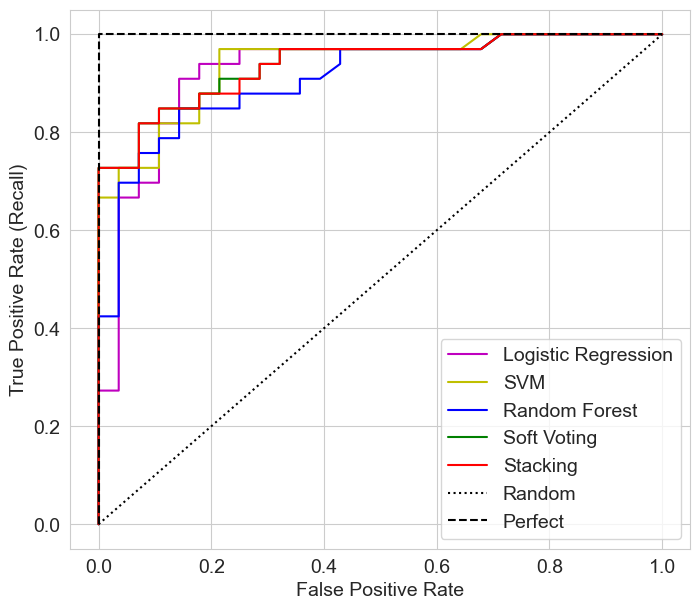

In [25]:
# Create a dictionary with the trained models
models = {'Logistic Regression' : [model_lr, 'm-'],
          'SVM' : [model_svm, 'y-'],
          'Random Forest' : [model_rf, 'b-'],
          'Soft Voting' : [model_sf, 'g-'],
          'Stacking' : [model_sk, 'r']}
fig, ax = plot_roc_curves(models, X_test, y_test, figsize=(8,7))

The ROC-curve plot indicates that **Soft Voting** and **Stacking** cover a higher area than the other methods. However, it is shown that the two architectures perform worse than Logistic Regression and SVM for high true positive rates. It is also observed that Random Forest performs worse than the other ensemble learning approaches.

## ROC AUC Scores

In [26]:
# Find the model with the highest ROC AUC score
best_score = 0
for key, model in models.items():
    if key == 'logistic regression':
        score = roc_auc_score(y_test, model[0].predict_proba(X_test)[:,1])
    else:
        score = roc_auc_score(y_test, model[0].predict_proba(X_test)[:,1])
    if score > best_score:
        best_score = score
        best_model = key

print(f"Model with the best ROC_AUC score: **{best_model}**")
print(f"- ROC AUC score: {round(best_score, 2)}")

Model with the best ROC_AUC score: **Soft Voting**
- ROC AUC score: 0.94


The **Soft Voting** ensemble method produces the highest ROC AUC score, along with **Stacking**.

## F1 Scores

In [27]:
# Find the model with the highest F1 score for a target recall of 90%
tpr = 0.90
best_score = 0
for key, model in models.items():
    thr, _ = find_roc_threshold_tpr(model[0], X_test, y_test, tpr)
    score = f1_score(y_test, model[0].predict_proba(X_test)[:,1] >= thr)    
    if score > best_score:
        best_score = score
        best_model = key
        best_thr = thr
print(f"Model with the best F1 score for a recall of {100*tpr}%: **{best_model}**")         
print(f"- Threshold: {round(best_thr, 2)}")
print(f"- F1 score: {round(best_score, 2)}")

Model with the best F1 score for a recall of 90.0%: **Logistic Regression**
- Threshold: 0.59
- F1 score: 0.9


**Logistic Regression** obtains the best results in therms of F1 score for a target recall of 90%.

## Generalization

In [28]:
# Find the model that achieves the lowest difference between the accuracy scores on the training set and those on the test set. At the same time, the best model should also produce the highest accuracy score.
lowest_diff = 1
best_score_test = 0
for key, model in models.items():
    score_train = accuracy_score(y_train, model[0].predict(X_train))
    score_test = accuracy_score(y_test, model[0].predict(X_test))
    diff = np.abs(score_train - score_test)
    if (diff <= lowest_diff) and (score_test >= best_score_test):
        lowest_diff = diff
        best_score_test = score_test
        best_model = key

print(f"Best generalizing model: **{best_model}**")

Best generalizing model: **SVM**


The **SVM** model is the one that best generalizes.

## Confusion Matrix for a 90% Recall

In [29]:
# Find the false positive rate corresponding to a recall of 90% using Logistic Regression and Soft Voting.
tpr = 0.90
thr_lr, fpr_lr = find_roc_threshold_tpr(model_lr, X_test, y_test, tpr)
print("Logistic Regression:")
print(f"- Threshold for a recall of {100*tpr}%: {round(thr_lr, 2)}")
print(f"- False positive rate: {round(fpr_lr, 2)}")
thr_sf, fpr_sf = find_roc_threshold_tpr(model_sf, X_test, y_test, tpr)
print("Soft Voting:")
print(f"- Threshold for a recall of {100*tpr}%: {round(thr_sf, 2)}")
print(f"- False positive rate: {round(fpr_sf, 2)}")

Logistic Regression:
- Threshold for a recall of 90.0%: 0.59
- False positive rate: 0.14
Soft Voting:
- Threshold for a recall of 90.0%: 0.59
- False positive rate: 0.21


**Logistic Regression** achieves the lowest false positive rate.

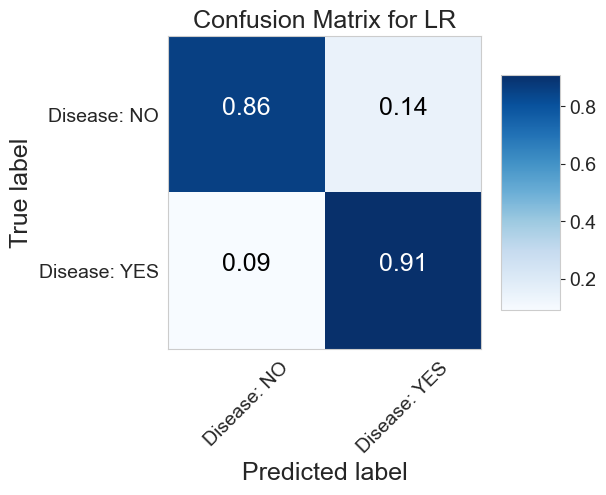

In [30]:
# Plot confusion matrix on the test set for Logistic Regression
y_test_pred = model_lr.predict_proba(X_test)[:,1] >= thr_lr
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, ['Disease: NO', 'Disease: YES'], normalize=True, title='Confusion Matrix for LR', cmap=plt.cm.Blues, figsize=(6,6))

The confusion matrix shows a true positive rate of 91% (with only 9% of false negative rate) and a false positive rate of 18%, when evaluating the **Logistic Regression** model.

# Conclusions
<a id='conclusions'><a>

In this work, we have analyzed the potential of some ensemble architectures to enhance the prediction performance for the heart-attack database. **Soft Voting Stacking achieves the best results in terms of ROC AUC**.

The non-ensemble methods, such as SVM and Logistic Regression, perform slightly better than the ensemble approaches at high values of recall. For a target recall of 90%, **Logistic Regression obtains the best F1 score** and **SVM is the machine-learning model that best generalizes**.

According to the confusion matrix, when using **Logistic Regression**, the achieved true positive and false positive rates are, respectively, **91% and 18%**.